<a href="https://colab.research.google.com/github/jm5159/E4511-2021-Mao/blob/master/EDA_noAMPL_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis
In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. Add the Columbia_E4511 folder to your google drive
3. For homework, you will work on this entire notebook for your own targets. Download them here:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/

## Mount your drive where you have the Columbia_E4511 folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install packages

In [ ]:
! pip install molvs

     |████████████████████████████████| 71kB 3.1MB/s 
  Created wheel for molvs: filename=MolVS-0.1.1-cp37-none-any.whl size=32376 sha256=a8bde368fbf62d0ae160d27f8f967f5c73a9669fbd3f4df0e5324a33d1840507
  Stored in directory: /root/.cache/pip/wheels/30/37/a8/8ac8147605c9de6b45ffd66d1cc19761d41467db12b34a0de8
Successfully built molvs


In [ ]:
# thanks to https://web.navan.dev/posts/2020-07-01-Install-rdkit-colab/
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [ ]:
sys.path.append('/content/drive/MyDrive/Columbia_E4511/AMPL_EDA')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/root/miniconda/lib/python3.7/site-packages',
 '/content/drive/MyDrive/Columbia_E4511/AMPL_EDA']

## Load packages

In [ ]:
%matplotlib inline
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
import struct_utils
import curate_data
import dist_metrics

# visualize compound structures
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display

# visualize data
import seaborn as sns
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

## Load data

In [ ]:
chembl = pd.read_table("/content/drive/MyDrive/Columbia_E4511/chembl.tsv")
dtc = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/DTC_CYP3A4.csv")
excape = pd.read_table("/content/drive/MyDrive/Columbia_E4511/CYP3A4_excape.tsv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,8,19,22,23,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Examine data
- what molecular (and other) identifiers exist for compounds from each database?
- what assay response types are there in each file?
- think about how we might combine these data sources together

In [ ]:
chembl.columns = chembl.columns.str.replace(' ','_') # get rid of annoying spaces
print(chembl.shape)

(9902, 41)


In [ ]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID
0,CHEMBL240954,NaN,0,516.46,2,1.92,9,CC(=O)O[C@H]1[C@H](C)O[C@@H](Oc2c(-c3ccc(O)cc3...,IC50,'=',20600.0,nM,4.69,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL1000805,Inhibition of human CYP3A4 by radiometric assay,A,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1151241,1,Scientific Literature,J. Nat. Prod.,2004.0,None
1,CHEMBL393363,NaN,0,528.54,1,3.67,29-rac,CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...,IC50,'=',120.0,nM,6.92,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL898579,Inhibition of CYP3A4,A,BAO_0000357,single protein format,None,None,None,None,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1149625,1,Scientific Literature,Bioorg. Med. Chem.,2007.0,None
2,CHEMBL398584,NaN,0,496.52,0,2.93,26-rac,CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...,IC50,'=',860.0,nM,6.07,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL898579,Inhibition of CYP3A4,A,BAO_0000357,single protein format,None,None,None,None,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1149625,1,Scientific Literature,Bioorg. Med. Chem.,2007.0,None
3,CHEMBL514681,NaN,0,406.91,0,4.29,8,O=C(CCc1ccccc1)NCC(=O)NC(c1ccccc1)c1ccc(Cl)cc1,IC50,'>',50000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL995045,Inhibition of CYP3A4,A,BAO_0000357,single protein format,None,None,None,None,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1144246,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None
4,CHEMBL452423,NaN,0,379.85,0,3.37,14,O=C(CNC(=O)c1ccncc1)NC(c1ccccc1)c1ccc(Cl)cc1,IC50,'>',50000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL995045,Inhibition of CYP3A4,A,BAO_0000357,single protein format,None,None,None,None,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1144246,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None


In [ ]:
chembl.Standard_Type.value_counts()

IC50    9902
Name: Standard_Type, dtype: int64

## Exercise: Explore datasets
- load dtc and excape datasets with pandas
- explore the dataframes
- answer questions below

Number of data points in each file:

Molecular identifiers from each file:

Data types from each file:

Data units in each file:

What is the formula to translate IC50 to pIC50?

What other information might be useful?

In [ ]:
# explore here

In [ ]:
dtc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47075 entries, 0 to 47074
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   compound_id                        46738 non-null  object 
 1   standard_inchi_key                 46360 non-null  object 
 2   compound_name                      8580 non-null   object 
 3   synonym                            3 non-null      object 
 4   target_id                          47075 non-null  object 
 5   target_pref_name                   47075 non-null  object 
 6   gene_names                         47039 non-null  object 
 7   wildtype_or_mutant                 44 non-null     object 
 8   mutation_info                      6 non-null      object 
 9   pubmed_id                          13408 non-null  float64
 10  standard_type                      47075 non-null  object 
 11  standard_relation                  35064 non-null  obj

In [ ]:
excape.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19324 entries, 0 to 19323
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ambit_InchiKey     19324 non-null  object 
 1   Original_Entry_ID  19324 non-null  object 
 2   Entrez_ID          19324 non-null  int64  
 3   Activity_Flag      19324 non-null  object 
 4   pXC50              14387 non-null  float64
 5   DB                 19324 non-null  object 
 6   Original_Assay_ID  19324 non-null  int64  
 7   Tax_ID             19324 non-null  int64  
 8   Gene_Symbol        19324 non-null  object 
 9   Ortholog_Group     19324 non-null  object 
 10  SMILES             19324 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 1.6+ MB


In [ ]:
dtc.head()

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments
0,CHEMBL268868,AAALVYBICLMAMA-UHFFFAOYSA-N,DAPH,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,NaN,POTENCY,=,1584.9,NM,Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: qHTS Assay for Inhibitors an...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN
1,CHEMBL268868,AAALVYBICLMAMA-UHFFFAOYSA-N,DAPH,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,NaN,POTENCY,=,1584.9,NM,Not Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PUBCHEM_BIOASSAY: qHTS Assay for Activators of...,PUBCHEM BIOASSAY DATA SET,NaN,DATASET,NaN
2,CHEMBL1800663,AAAOTGDHZDZLFN-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,21657270.0,INHIBITION,=,64.0,%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human CYP3A4 assessed as convers...,"Discovery of 1-{4-[1-(2,6-difluorobenzyl)-5-[(...",J. Med. Chem.,PUBLICATION,NaN
3,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,24015967.0,IC50,>=,33000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human CYP3A4,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN
4,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,24015967.0,INHIBITION,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Time-dependent inhibition of human CYP3A4,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN


In [ ]:
dtc.gene_names.unique()

array(['CYP3A4', 'HTR1A', 'NR1I2', 'CYP3A5', 'ABCB1', 'CYP2D6', 'CYP2C19',
       'CYP2C9', 'CYP1A2', 'CYP3A4, CYP3A5', 'PDE2A', 'GNRHR', 'NAMPT',
       'CYP3A4, CYP3A43, CYP3A5, CYP3A7, CYP3A7-CYP3A51P', 'PIK3CD',
       'PTGDR2', 'PTGDR', 'CYP17A1', nan, 'KCNQ2', 'VDR', 'CYP19A1',
       'CYP3A43', 'CYP2A6', 'CYP2C8', 'CYP1A1', 'MCHR1', 'KCNH2'],
      dtype=object)

# EDA: assay data responses
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [ ]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID
0,CHEMBL240954,NaN,0,516.46,2,1.92,9,CC(=O)O[C@H]1[C@H](C)O[C@@H](Oc2c(-c3ccc(O)cc3...,IC50,'=',20600.0,nM,4.69,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL1000805,Inhibition of human CYP3A4 by radiometric assay,A,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1151241,1,Scientific Literature,J. Nat. Prod.,2004.0,None
1,CHEMBL393363,NaN,0,528.54,1,3.67,29-rac,CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...,IC50,'=',120.0,nM,6.92,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL898579,Inhibition of CYP3A4,A,BAO_0000357,single protein format,None,None,None,None,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1149625,1,Scientific Literature,Bioorg. Med. Chem.,2007.0,None
2,CHEMBL398584,NaN,0,496.52,0,2.93,26-rac,CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(C)=O)C(=O)C...,IC50,'=',860.0,nM,6.07,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL898579,Inhibition of CYP3A4,A,BAO_0000357,single protein format,None,None,None,None,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1149625,1,Scientific Literature,Bioorg. Med. Chem.,2007.0,None
3,CHEMBL514681,NaN,0,406.91,0,4.29,8,O=C(CCc1ccccc1)NCC(=O)NC(c1ccccc1)c1ccc(Cl)cc1,IC50,'>',50000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL995045,Inhibition of CYP3A4,A,BAO_0000357,single protein format,None,None,None,None,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1144246,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None
4,CHEMBL452423,NaN,0,379.85,0,3.37,14,O=C(CNC(=O)c1ccncc1)NC(c1ccccc1)c1ccc(Cl)cc1,IC50,'>',50000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL995045,Inhibition of CYP3A4,A,BAO_0000357,single protein format,None,None,None,None,None,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1144246,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None


In [ ]:
chembl.Standard_Units.unique()

array(['nM', nan, 'ug.mL-1', 'min'], dtype=object)

## **Curation step**: change units to be the same for all responses

In [ ]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

## EDA: Summarize, describe, plot data for analysis

In [ ]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Source_ID,Document_Year,Standard_Value_nM
count,9902.000000,8.629000e+03,4853.000000,586.000000,586.000000,586.000000,586.000000,9902.000000,8868.00000,8.629000e+03
mean,0.436477,8.425227e+04,5.475024,11.300256,0.213481,1.272799,6.944829,6.344476,2012.20106,8.425227e+04
std,1.214395,1.800720e+06,0.899686,5.845508,0.109255,1.340193,6.052495,11.520291,3.73373,1.800720e+06
min,0.000000,0.000000e+00,4.000000,4.920000,0.090000,-3.520000,1.980000,1.000000,1992.00000,0.000000e+00
25%,0.000000,3.000000e+03,4.820000,7.400000,0.140000,0.580000,4.040000,1.000000,2010.00000,3.000000e+03
50%,0.000000,1.000000e+04,5.300000,10.030000,0.190000,1.440000,5.220000,1.000000,2012.00000,1.000000e+04
75%,0.000000,2.750000e+04,5.960000,12.760000,0.247500,2.140000,6.992500,1.000000,2015.00000,2.750000e+04
max,4.000000,7.762471e+07,10.300000,55.910000,1.030000,5.080000,57.320000,38.000000,2018.00000,7.762471e+07


- **Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries**


In [ ]:
chembl=chembl.replace('None',np.nan)

In [ ]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

In [ ]:
chembl.describe()

,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Source_ID,Document_Year,Standard_Value_nM
count,9902.000000,9890.000000,9827.000000,9827.000000,8.629000e+03,4853.000000,586.000000,586.000000,586.000000,586.000000,9902.000000,8868.00000,8.629000e+03
mean,0.436477,445.575144,0.516231,3.877403,8.425227e+04,5.475024,11.300256,0.213481,1.272799,6.944829,6.344476,2012.20106,8.425227e+04
std,1.214395,143.272232,0.738861,1.594890,1.800720e+06,0.899686,5.845508,0.109255,1.340193,6.052495,11.520291,3.73373,1.800720e+06
min,0.000000,32.050000,0.000000,-13.050000,0.000000e+00,4.000000,4.920000,0.090000,-3.520000,1.980000,1.000000,1992.00000,0.000000e+00
25%,0.000000,360.870000,0.000000,2.970000,3.000000e+03,4.820000,7.400000,0.140000,0.580000,4.040000,1.000000,2010.00000,3.000000e+03
50%,0.000000,433.370000,0.000000,3.870000,1.000000e+04,5.300000,10.030000,0.190000,1.440000,5.220000,1.000000,2012.00000,1.000000e+04
75%,0.000000,513.827500,1.000000,4.840000,2.750000e+04,5.960000,12.760000,0.247500,2.140000,6.992500,1.000000,2015.00000,2.750000e+04
max,4.000000,2296.970000,4.000000,9.910000,7.762471e+07,10.300000,55.910000,1.030000,5.080000,57.320000,38.000000,2018.00000,7.762471e+07


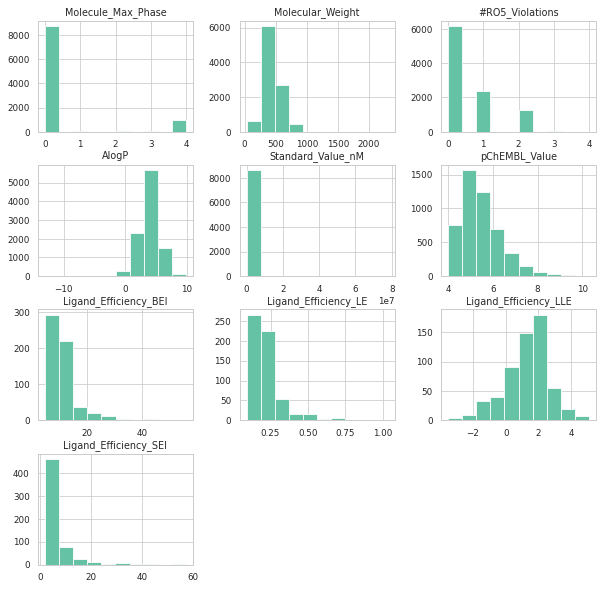

In [ ]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types / assays represented in the value columns. Let's split those up:**

Standard_Type,IC50
count,7.090000e+03
mean,6.774203e+04
std,1.121467e+06
min,0.000000e+00
25%,3.300000e+03
50%,1.000000e+04
75%,2.900000e+04
max,3.885116e+07


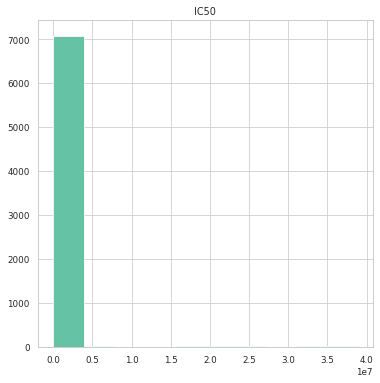

In [ ]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the standard values?**

Standard_Type,IC50
count,4054.000000
mean,5.467381
std,0.878229
min,4.000000
25%,4.840000
50%,5.300000
75%,5.920000
max,10.300000


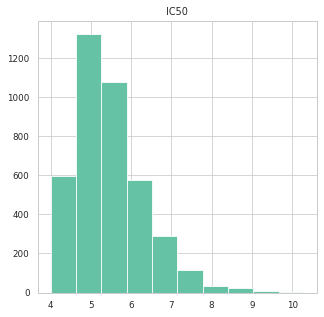

In [ ]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(5,5));

- **What do you notice about the pChEMBL values?**

## Exercise: explore DTC and Excape data the same way
- **Curation step:** add pValue column from raw measurements if it doesn't exist

In [ ]:
dtc_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/3873013478030068339.txt", sep="\t", header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL268868,C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
1,CHEMBL268868,C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
2,CHEMBL1800663,CN(CCC1=CC=CC=N1)CC2=C(SC3=C2C(=O)N(C(=O)N3CC4...
3,CHEMBL1232461,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...
4,CHEMBL1232461,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...


In [ ]:
dtc['SMILES'] = dtc['compound_id'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [ ]:
print("No ChemblID in DTC:", len(dtc[dtc['compound_id'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 337
No SMILES from ChemblID in DTC: 658


In [ ]:
dtc = dtc[(dtc.gene_names=='CYP3A4')&(dtc.standard_type == 'IC50')&
          (dtc.standard_units == 'NM')&~(dtc.standard_inchi_key.isna())&
          ~(dtc.standard_value.isna()) &~(dtc.compound_id.isna()) &
          (dtc.wildtype_or_mutant != 'mutated')]

In [ ]:
dtc.reset_index(drop=True)

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,SMILES
0,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,24015967.0,IC50,>=,33000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human CYP3A4,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...
1,CHEMBL2158292,AADUJBXZMSDOOW-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,22039836.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Optimization of a potent class of arylamide co...,J. Med. Chem.,PUBLICATION,NaN,C1CCC(=CC1)C2=C(C=CC(=C2)C3CCN(CC3)C(=O)C4=CC=...
2,CHEMBL1086377,AATCBLYHOUOCTO-UHFFFAOYSA-N,KU-0060648,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,23855836.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 (unknown origin),"1-substituted (Dibenzo[b,d]thiophen-4-yl)-2-mo...",J. Med. Chem.,PUBLICATION,NaN,CCN1CCN(CC1)CC(=O)NC2=C3C4=CC=CC=C4SC3=C(C=C2)...
3,CHEMBL2017279,AAVAYKQPRIQKRX-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,22386529.0,IC50,=,1500.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,From ApoA1 upregulation to BET family bromodom...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,CC1=C(C(=NO1)C)C2=C(C=C3C(=C2)N=CC(=C3NC4=CC=C...
4,CHEMBL490153,ABACVOXFUHDKNZ-UHFFFAOYSA-N,A-867744,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,19419141.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Discovery of 4-(5-(4-chlorophenyl)-2-methyl-3-...,J. Med. Chem.,PUBLICATION,NaN,CCC(=O)C1=C(N(C(=C1)C2=CC=C(C=C2)Cl)C3=CC=C(C=...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6479,CHEMBL1076536,ZZHNYWHADLVCEP-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,19846298.0,IC50,=,5500.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 using diethoxyfluorescein...,"Evaluation of basic, heterocyclic ring systems...",Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,CC1=C(C(=CC=C1)C)COC2=CC=CN3C2=NC(=C3C)C
6480,CHEMBL1076536,ZZHNYWHADLVCEP-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,19846298.0,IC50,=,18000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 using 7-benzyloxyquinolin...,"Evaluation of basic, heterocyclic ring systems...",Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,CC1=C(C(=CC=C1)C)COC2=CC=CN3C2=NC(=C3C)C
6481,CHEMBL3087341,ZZNSTCGBKYJVKR-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,24139583.0,IC50,>,27000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 (unknown origin) after 5 ...,Discovery of 2-methylpyridine-based biaryl ami...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,CC1=NC=CC(=C1)C2=CC=C(C=C2)NC(=O)CC3=CC(=CC(=C...
6482,CHEMBL2181641,ZZYHXFCSTOMZNZ-LICLKQGHSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,22849725.0,IC50,=,1500.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Discovery of the first thumb pocket 1 NS5B pol...,J. Med. Chem.,PUBLICATION,NaN,CN1C2=C(C=CC(=C2)C(=O)NC3(CCC3)C(=O)NC4=CC=C(C...


In [ ]:
dtc.describe()

,pubmed_id,standard_value
count,5.789000e+03,6.484000e+03
mean,2.085258e+07,9.762973e+04
std,4.050705e+06,2.039815e+06
min,-1.000000e+00,5.030000e-02
25%,1.900667e+07,2.250000e+03
50%,2.137658e+07,1.000000e+04
75%,2.362367e+07,2.720000e+04
max,2.795593e+07,7.762471e+07


In [ ]:
dtc.head()

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,SMILES
3,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,24015967.0,IC50,>=,33000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human CYP3A4,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...
15,CHEMBL2158292,AADUJBXZMSDOOW-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,22039836.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Optimization of a potent class of arylamide co...,J. Med. Chem.,PUBLICATION,NaN,C1CCC(=CC1)C2=C(C=CC(=C2)C3CCN(CC3)C(=O)C4=CC=...
56,CHEMBL1086377,AATCBLYHOUOCTO-UHFFFAOYSA-N,KU-0060648,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,23855836.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 (unknown origin),"1-substituted (Dibenzo[b,d]thiophen-4-yl)-2-mo...",J. Med. Chem.,PUBLICATION,NaN,CCN1CCN(CC1)CC(=O)NC2=C3C4=CC=CC=C4SC3=C(C=C2)...
59,CHEMBL2017279,AAVAYKQPRIQKRX-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,22386529.0,IC50,=,1500.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,From ApoA1 upregulation to BET family bromodom...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,CC1=C(C(=NO1)C)C2=C(C=C3C(=C2)N=CC(=C3NC4=CC=C...
67,CHEMBL490153,ABACVOXFUHDKNZ-UHFFFAOYSA-N,A-867744,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,19419141.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Discovery of 4-(5-(4-chlorophenyl)-2-methyl-3-...,J. Med. Chem.,PUBLICATION,NaN,CCC(=O)C1=C(N(C(=C1)C2=CC=C(C=C2)Cl)C3=CC=C(C=...


In [ ]:
dtc['pDTC_Value'] = np.where(dtc.standard_units == 'NM',-np.log10(dtc.standard_value/1000000000 ),dtc.standard_value)

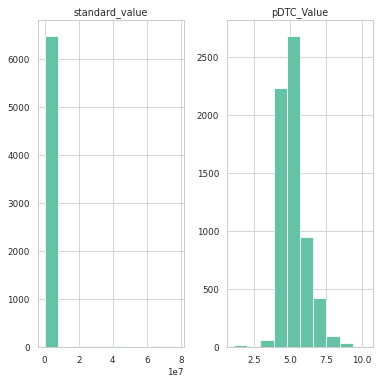

In [ ]:
dtc[['standard_value','pDTC_Value']].hist(figsize=(6,6));

In [ ]:
excape.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,YAYNEUUHHLGGAH-UHFFFAOYNA-N,8192,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ClCCCCCCCCCCCC
1,LUVCTYHBTXSAMX-UHFFFAOYNA-N,8783,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ClCCOP(OCCCl)OCCCl
2,FAGUFWYHJQFNRV-UHFFFAOYNA-N,8197,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,N(CCNCCN)CCNCCN
3,HQUQLFOMPYWACS-UHFFFAOYNA-N,8295,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ClCCOP(OCCCl)(OCCCl)=O
4,JVGPVVUTUMQJKL-UHFFFAOYNA-N,8196,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,S(CCOCCOCCCC)C#N


In [ ]:
excape.describe()

,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID
count,19324.0,14387.000000,1.932400e+04,19324.0
mean,1576.0,5.259378,5.141160e+05,9606.0
std,0.0,0.674275,3.458763e+05,0.0
min,1576.0,1.300000,8.840000e+02,9606.0
25%,1576.0,4.800000,8.850000e+02,9606.0
50%,1576.0,5.100000,7.378250e+05,9606.0
75%,1576.0,5.550000,7.378250e+05,9606.0
max,1576.0,10.660000,1.367425e+06,9606.0


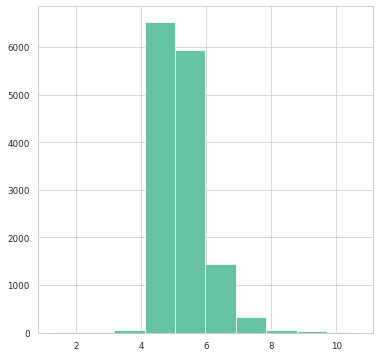

In [ ]:
excape['pXC50'].hist(figsize=(6,6));

## EDA & Exercise: compare pResponse values across all three datasets
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

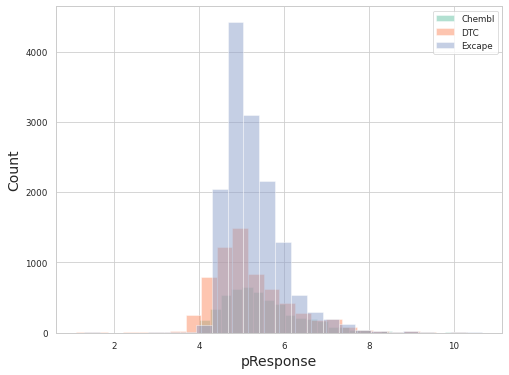

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(chembl['pChEMBL_Value'], bins=25, alpha=0.5, label="Chembl")
plt.hist(dtc['pDTC_Value'], bins=25, alpha=0.5, label="DTC")
plt.hist(excape['pXC50'], bins=25, alpha=0.5, label="Excape")
plt.xlabel("pResponse", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')

In [ ]:
#dtc.to_csv('dtc_temp.csv', index=False)

## Exercise: analyze & discuss
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

IC50

# EDA: Compounds

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets / excel
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

In [ ]:
# open file from pubchem ID exchange service
dtc_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/3873013478030068339.txt", sep="\t", header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL268868,C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
1,CHEMBL268868,C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
2,CHEMBL1800663,CN(CCC1=CC=CC=N1)CC2=C(SC3=C2C(=O)N(C(=O)N3CC4...
3,CHEMBL1232461,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...
4,CHEMBL1232461,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...


In [ ]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['compound_id'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [ ]:
# what's missing?
print("No ChemblID in DTC:", len(dtc[dtc['compound_id'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 337
No SMILES from ChemblID in DTC: 658


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [ ]:
# try it yourself here

## EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

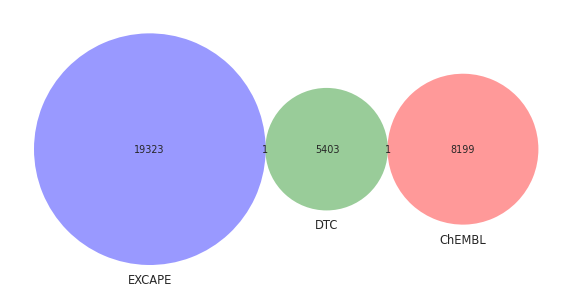

In [ ]:
# overlaps from SMILES strings
mpv.venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

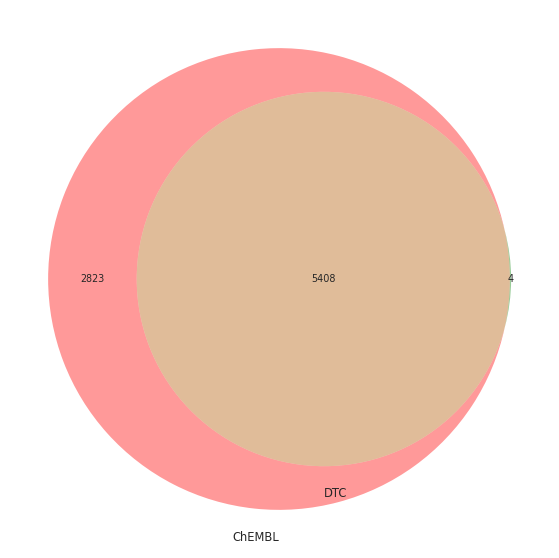

In [ ]:
# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists
mpv.venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.compound_id)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

## **Curation step:** Standardize smiles strings, drop rows without base smiles

In [ ]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(struct_utils.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

9902
8200
8190


In [ ]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Standard_Value_nM,base_rdkit_smiles
28,CHEMBL136478,SODIUM NITROPRUSSIDE,4.0,261.92,NaN,NaN,SODIUM NITROPRUSSIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,
668,CHEMBL1909067,NaN,0.0,NaN,NaN,NaN,MC 258714,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,
669,CHEMBL1909074,POLYVINYLPYRROLIDONE,0.0,NaN,NaN,NaN,POLYVINYLPYRROLIDONE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,
739,CHEMBL1909055,COBALTOUS CHLORIDE,4.0,129.84,NaN,NaN,COBALT (II) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,
924,CHEMBL1201631,INSULIN,4.0,NaN,NaN,NaN,INSULIN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,CHEMBL414804,OXALIPLATIN,4.0,NaN,NaN,NaN,OXALIPLATIN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,
6205,CHEMBL1200693,MANGANESE CHLORIDE,4.0,125.84,NaN,NaN,MANGANESE (II) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,
6324,CHEMBL3559671,POLYVINYL ALCOHOL,4.0,NaN,NaN,NaN,POLYVINYL ALCOHOL,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_00002

In [ ]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Standard_Value_nM,base_rdkit_smiles
28,CHEMBL136478,SODIUM NITROPRUSSIDE,4.0,261.92,NaN,NaN,SODIUM NITROPRUSSIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN
668,CHEMBL1909067,NaN,0.0,NaN,NaN,NaN,MC 258714,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN
669,CHEMBL1909074,POLYVINYLPYRROLIDONE,0.0,NaN,NaN,NaN,POLYVINYLPYRROLIDONE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN
739,CHEMBL1909055,COBALTOUS CHLORIDE,4.0,129.84,NaN,NaN,COBALT (II) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN
924,CHEMBL1201631,INSULIN,4.0,NaN,NaN,NaN,INSULIN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,CHEMBL414804,OXALIPLATIN,4.0,NaN,NaN,NaN,OXALIPLATIN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN
6205,CHEMBL1200693,MANGANESE CHLORIDE,4.0,125.84,NaN,NaN,MANGANESE (II) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition (sub...",B,BAO_0000219,cell-based format,NaN,NaN,NaN,BTI-TN-5B1-4,NaN,CHEMBL340,Cytochrome P450 3A4,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3833782,NaN,NaN
6324,CHEMBL3559671,POLYVINYL ALCOHOL,4.0,NaN,NaN,NaN,POLYVINYL ALCOHOL,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909138,"DRUGMATRIX: CYP450, 3A4 enzyme inhibition

In [ ]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

## Exercise: standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [ ]:
dtc.head(3)

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,SMILES,pDTC_Value
3,CHEMBL1232461,AAAQFGUYHFJNHI-SFHVURJKSA-N,GSK525762A,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,24015967.0,IC50,>=,33000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human CYP3A4,Discovery of epigenetic regulator I-BET762: le...,J. Med. Chem.,PUBLICATION,NaN,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,4.481486
15,CHEMBL2158292,AADUJBXZMSDOOW-UHFFFAOYSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,22039836.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4,Optimization of a potent class of arylamide co...,J. Med. Chem.,PUBLICATION,NaN,C1CCC(=CC1)C2=C(C=CC(=C2)C3CCN(CC3)C(=O)C4=CC=...,5.000000
56,CHEMBL1086377,AATCBLYHOUOCTO-UHFFFAOYSA-N,KU-0060648,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,23855836.0,IC50,>,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 (unknown origin),"1-substituted (Dibenzo[b,d]thiophen-4-yl)-2-mo...",J. Med. Chem.,PUBLICATION,NaN,CCN1CCN(CC1)CC(=O)NC2=C3C4=CC=CC=C4SC3=C(C=C2)...,5.000000


In [ ]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(struct_utils.base_smiles_from_smiles)
print(len(dtc.SMILES))
print(len(dtc.SMILES.unique()))
print(len(dtc.base_rdkit_smiles.unique()))

6484
5405
5399


In [ ]:
dtc=dtc.replace('',np.nan)
dtc[dtc.base_rdkit_smiles.isna()]

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,SMILES,pDTC_Value,base_rdkit_smiles
43119,CHEMBL3216329,YFUUQKJOCLQHMZ-ISJKLOBTSA-N,NaN,NaN,P08684,CYTOCHROME P450 3A4,CYP3A4,NaN,NaN,22695132.0,IC50,>,20000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of CYP3A4 in human liver microsomes,Identification of a dual d OR antagonist/µ OR ...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,NaN,4.69897,NaN


In [ ]:
dtc=dtc[~dtc.base_rdkit_smiles.isna()]

In [ ]:
excape.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,YAYNEUUHHLGGAH-UHFFFAOYNA-N,8192,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ClCCCCCCCCCCCC
1,LUVCTYHBTXSAMX-UHFFFAOYNA-N,8783,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ClCCOP(OCCCl)OCCCl
2,FAGUFWYHJQFNRV-UHFFFAOYNA-N,8197,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,N(CCNCCN)CCNCCN
3,HQUQLFOMPYWACS-UHFFFAOYNA-N,8295,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ClCCOP(OCCCl)(OCCCl)=O
4,JVGPVVUTUMQJKL-UHFFFAOYNA-N,8196,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,S(CCOCCOCCCC)C#N


In [ ]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(struct_utils.base_smiles_from_smiles)
print(len(excape.SMILES))
print(len(excape.SMILES.unique()))
print(len(excape.base_rdkit_smiles.unique()))

19324
19324
19304


In [ ]:
excape=excape.replace('',np.nan)
excape[excape.base_rdkit_smiles.isna()]

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
749,RRSCJMKFYYSZES-UHFFFAOYNA-N,172268,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ON=1(CCN=2(O)CCCCC2)CCCCC1,NaN
1383,NVYHVHVSHFOAPB-UHFFFAOYNA-N,224948,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ON(=CC=1C=C(C=CC1O)C2=CC=CC=C2)(C)C,NaN
1490,QGTGMXPADSCUFS-KZFATGLANA-N,5351837,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ON(CCO)(=CCO)C1=NC=NC=2N=CNC12,NaN
4426,TXACMWZLLJFLER-UHFFFAOYNA-N,20313,1576,A,5.90001,pubchem,884,9606,CYP3A4,un4,ON(=CC=CC1C=2C(CCC=3C1=CC=CC3)=CC=CC2)(C)C,NaN
7753,MXZASAPEQAUAEP-REUGXJQINA-N,5771580,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ON=1([C@@H]2CCC1CC(OC(=O)[C@@H](CO)C3=CC=CC=C3...,NaN
7754,MXZASAPEQAUAEP-VADGTKANNA-N,3246272,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ON=1([C@H]2CCC1CC(OC(=O)[C@@H](CO)C3=CC=CC=C3)...,NaN
14961,XBRDHOJWZLJOJV-IPPOASPLNA-N,6604327,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,O1[C@H]2[C@@H]1[C@@H]3N(O)(=C2CC(OC(=O)[C@@H](...,NaN
17400,XYBAFMNNAXYCSR-YOSCJVSPNA-N,3246431,1576,N,NaN,pubchem,885,9606,CYP3A4,un4,ON1=2[C@H]3[C@@]4([C@H](NC5=C4C=CC=C5)[C@@H]6[...,NaN
19258,RTSGOHGMRQSVKL-STNGILPFNA-N,CHEMBL1314924,1576,N,4.40000,chembl20,688839,9606,CYP3A4,un4,OC1=C2C(=C(C=3C4=C(C(O)=C5C3C=CC=C5O[C@@H]6OC(...,NaN


In [ ]:
excape=excape[~excape.base_rdkit_smiles.isna()]

## **Curation step:** Save standardized datasets

In [ ]:
chembl.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_ChEMBL_SMILES.csv")
dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_DTC_SMILES.csv")
excape.to_csv("/content/drive/MyDrive/Columbia_E4511/CYP3A4_Excape_SMILES.csv")

## Exercise: examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

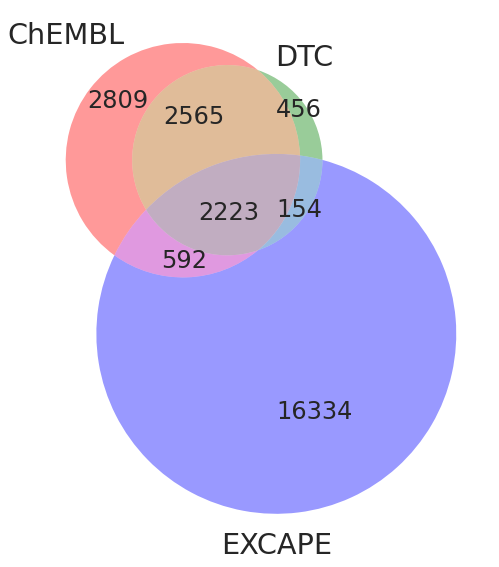

In [ ]:
mpv.venn3([set(chembl.base_rdkit_smiles),
           set(dtc.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

## EDA: Examine compound diversity

In [ ]:
import diversity_plots as dp
sns.set_context('poster')

2021-03-11 02:33:26,411 Starting distance matrix calculation for 9870 compounds
2021-03-11 02:34:10,248 Finished calculation of 48703515 distances


array([0.86607143, 0.85849057, 0.23076923, ..., 0.86065574, 0.872     ,
       0.84920635])

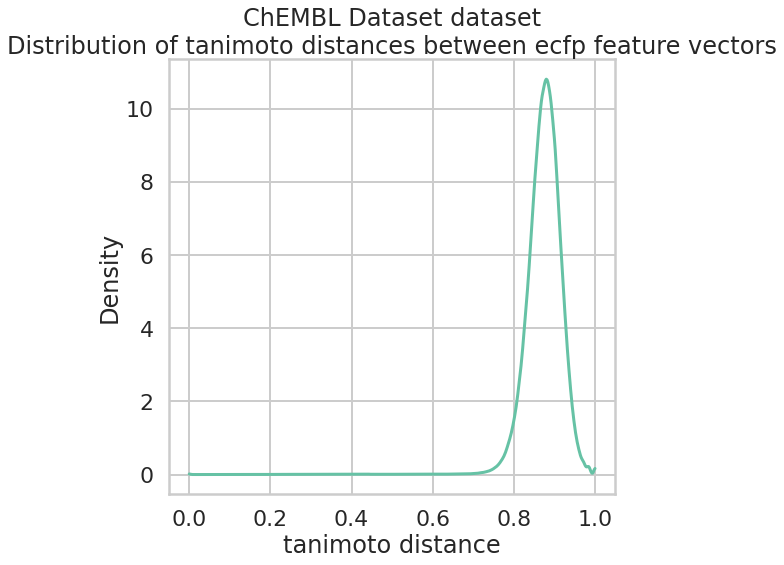

In [ ]:
dp.plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


KeyboardInterrupt: ignored

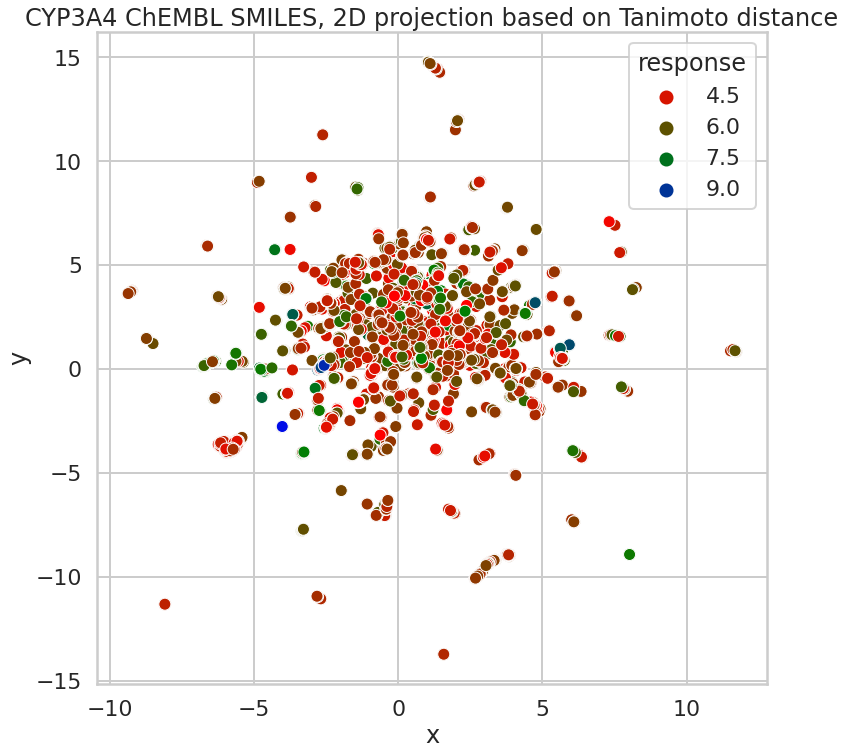

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP3A4_ChEMBL_SMILES.csv', 
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value')

## Exercise: create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

2021-03-11 02:44:29,742 Starting distance matrix calculation for 6483 compounds
2021-03-11 02:44:50,302 Finished calculation of 21011403 distances


array([0.88793103, 0.85585586, 0.87096774, ..., 0.90666667, 0.84415584,
       0.86915888])

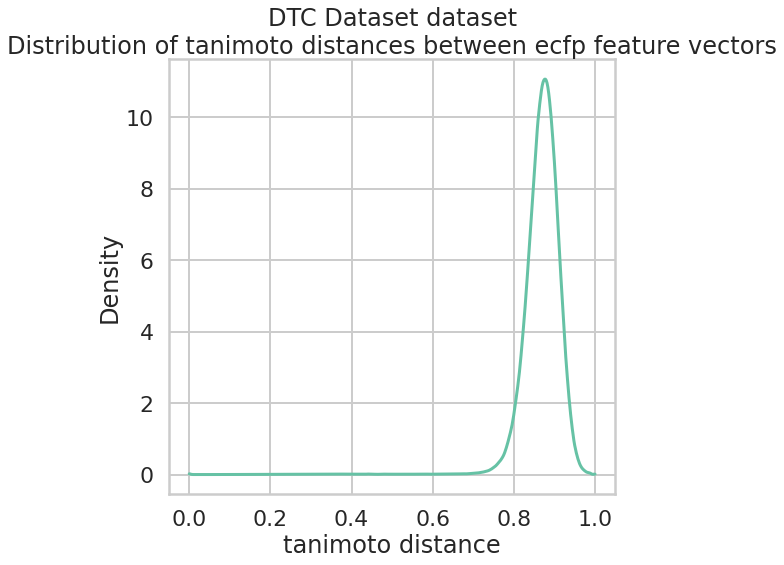

In [ ]:
dp.plot_tani_dist_distr(dtc, 'base_rdkit_smiles', 'DTC Dataset')

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP3A4_DTC_SMILES.csv', 
                   id_col ='compound_id', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pDTC_Value')

2021-03-11 02:45:45,058 Starting distance matrix calculation for 19315 compounds
2021-03-11 02:48:43,788 Finished calculation of 186524955 distances


array([0.81818182, 0.90909091, 0.95652174, ..., 0.7761194 , 0.68548387,
       0.88172043])

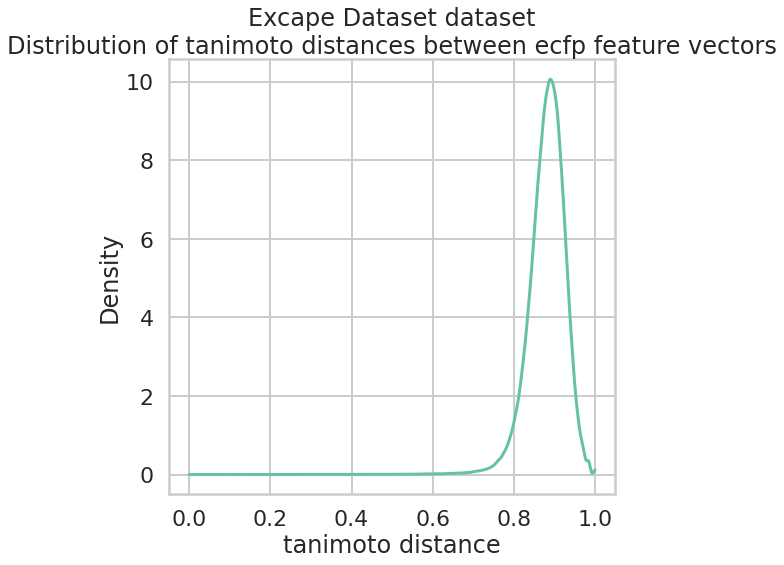

In [ ]:
dp.plot_tani_dist_distr(excape, 'base_rdkit_smiles', 'Excape Dataset')

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/CYP3A4_Excape_SMILES.csv', 
                   id_col ='Original_Entry_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50')

## Exercise: analyze and discuss these plots.
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
  - what radius and vector length are used in these functions?
  - hint: look at the .py files for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?

# EDA: Curated datasets